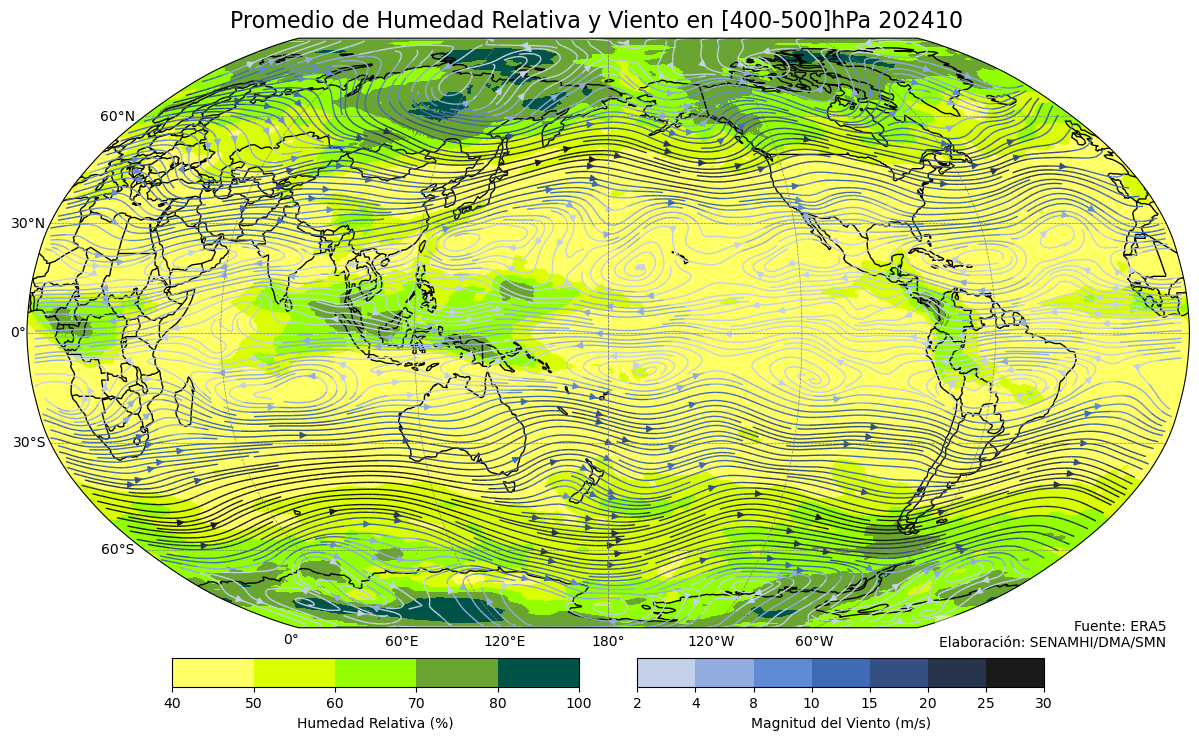

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import os

# Define la fecha inicial y crea la ruta al archivo GRIB
FECHA_INICIAL = 202410

# Definir la función para convertir longitudes
def convert_longitudes(lon):
    return (lon + 180) % 360 - 180

# Cargar el archivo GRIB
ds = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/ERA5/NIVELES/pgb_era5_{FECHA_INICIAL}.grib', engine='cfgrib')

# Convertir las longitudes del dataset
ds['longitude'] = convert_longitudes(ds['longitude'])

# Asegurarse de que los niveles de 400 hPa y 500 hPa estén disponibles
levels_to_average = [400, 500]
if all(level in ds['isobaricInhPa'].values for level in levels_to_average):
    # Seleccionar el único tiempo disponible
    time = ds['time'].values  # Extraer el único tiempo
    fecha_actual = pd.to_datetime(str(time))
    mes_titulo = fecha_actual.strftime("%Y%m")
    
    # Crear el directorio con el formato YYYYMM
    output_dir = f'/scratch/DMA/SMN/CLIMA/web_figuras/monitoreo/mensual'
    # os.makedirs(output_dir, exist_ok=True)

    # Seleccionar las variables rh, u y v para los niveles de 400 hPa y 500 hPa
    rh_400 = ds['r'].sel(isobaricInhPa=400)
    rh_500 = ds['r'].sel(isobaricInhPa=500)
    u_400 = ds['u'].sel(isobaricInhPa=400)
    u_500 = ds['u'].sel(isobaricInhPa=500)
    v_400 = ds['v'].sel(isobaricInhPa=400)
    v_500 = ds['v'].sel(isobaricInhPa=500)

    # Calcular el promedio de rh, u y v entre 400 hPa y 500 hPa
    rh_avg = (rh_400 + rh_500) / 2
    u_avg = (u_400 + u_500) / 2
    v_avg = (v_400 + v_500) / 2

    # Coordenadas de longitud y latitud
    lon = ds['longitude']
    lat = ds['latitude']
    lon2d, lat2d = np.meshgrid(lon, lat)

    # Calcular la magnitud del viento
    wind_magnitude = np.sqrt(u_avg**2 + v_avg**2)

    # Crear una figura y un eje con una proyección Robinson y longitud central de 180 grados
    fig, ax = plt.subplots(figsize=(15, 11), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    ax.set_global()

    # Definir los colores y valores para la humedad relativa
    rh_colors = ['#FFFF66', '#D9FF00', '#93FF00', '#6BA531', '#00724B', '#005447']
    rh_values = [40, 50, 60, 70, 80, 100]

    rh_cmap = ListedColormap(rh_colors)
    rh_norm = BoundaryNorm(rh_values, len(rh_colors))

    # Graficar la humedad relativa usando pcolormesh para una mayor personalización
    rh_plot = ax.pcolormesh(lon, lat, rh_avg, transform=ccrs.PlateCarree(), cmap=rh_cmap, norm=rh_norm, shading='auto')

    # Añadir barra de color para la humedad relativa
    cax_q = inset_axes(ax, width="35%", height="4%", loc='lower center', bbox_to_anchor=(-0.2, -0.1, 1, 1.2), bbox_transform=ax.transAxes, borderpad=0)
    cbar_q = plt.colorbar(rh_plot, cax=cax_q, orientation='horizontal')
    cbar_q.set_label('Humedad Relativa (%)')
    cbar_q.set_ticks(rh_values)

    # Añadir características al mapa
    land_color = np.array([254, 227, 170]) / 255  # Convertir RGB a escala 0-1
    ax.add_feature(cfeature.LAND, facecolor=land_color)
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    # Definir los colores y valores para las líneas de corriente
    wind_colors = ['#C2D0E9', '#91ACDF', '#618AD5', '#416AB6', '#345082', '#27344D', '#1A1A1A']
    wind_values = [2, 4, 8, 10, 15, 20, 25, 30]

    wind_norm = BoundaryNorm(wind_values, len(wind_colors))
    wind_cmap = ListedColormap(wind_colors)

    # Trazar líneas de corriente con color según la magnitud del viento
    strm = ax.streamplot(lon2d, lat2d, u_avg.values, v_avg.values,
                         color=wind_magnitude.values, linewidth=1, cmap=wind_cmap, norm=wind_norm, density=5, transform=ccrs.PlateCarree())

    # Añadir barra de color para la magnitud del viento
    cax_wind = inset_axes(ax, width="35%", height="4%", loc='lower center', bbox_to_anchor=(0.2, -0.1, 1, 1.2), bbox_transform=ax.transAxes, borderpad=0)
    cbar_wind = plt.colorbar(strm.lines, cax=cax_wind, orientation='horizontal')
    cbar_wind.set_label('Magnitud del Viento (m/s)')
    cbar_wind.set_ticks(wind_values)

    # Añadir líneas de cuadrícula y etiquetas para latitud y longitud
    gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # Mostrar la figura con el título actualizado
    plt.title(f'Promedio de Humedad Relativa y Viento en [400-500]hPa {mes_titulo}', y=23, x=-0.1, fontsize=16)
    # Añadir la anotación
    plt.annotate('Fuente: ERA5\nElaboración: SENAMHI/DMA/SMN', xy=(1.3, 1.3), xycoords='axes fraction', fontsize=10,
                 ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.5))

    # Guardar la figura con resolución de 300 DPI y la fecha en el nombre del archivo
    fig.savefig(f'{output_dir}/era5_{mes_titulo}_vientoHum400-500hpa_glob.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Los niveles de 400 hPa y 500 hPa no están disponibles en el dataset.")
